# Fixed Cell Analysis – Multi-channel spot detection
<a id='section0'></a>
***

In [1]:
import glob, os, random, re, sys, math, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import ipywidgets as widgets
import trackpy as tp
import tensorflow as tf

import pims
import skimage.io
import skimage.feature
import skimage.filters
import skimage.segmentation
import skimage.morphology
import skimage.measure

import stardist.models
import utils.model_builder
import utils.predictions

model_unet = utils.model_builder.standard_unet()
model_unet.load_weights('./models/UNet.h5')
model_star = stardist.models.StarDist2D(None, name='Stardist', basedir='./models/')

/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/beichenberger/anac

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.







Loading network weights from 'weights_best.h5'.


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.455612, nms_thresh=0.3.


## 1. Image import
<a id='section1'></a>

In [2]:
root = './data'
channels = 3

In [3]:
def get_root_files(root, extension='nd'):
    files = sorted(glob.glob(f'{root}/*.{extension}'))
    files = [f.split('/')[-1] for f in files]
    files = [f.split('.')[0] for f in files]
    return files

def get_stk_files(root, file):
    files = glob.glob(f'{root}/{file}*.stk')
    return files

In [4]:
# Nd / stk files
files = get_root_files(root, 'nd')

@widgets.interact(file=widgets.Dropdown(options=files, description='File: '),
                  sharp=widgets.Checkbox(value=False, description='Use sharpest slice'))
def f(file, sharp):
    global img_file, img, var_sharp
    img_file = file
    img_files = get_stk_files(root, file)
    var_sharp = sharp
    img = list(map(skimage.io.imread, img_files))
    img = np.array(img)
    
    @widgets.interact(frame = widgets.IntSlider(value=img.shape[1]//2, min=1, max=img.shape[1]-1, description='Slice: '))
    def g(frame):
        img_plot = img[:, frame]
        fig, ax = plt.subplots(1, 3, figsize=(15,10))
        for i, image in enumerate(img_plot):
            ax[i].set_title(f'Channel {i}')
            ax[i].imshow(img_plot[i])
        plt.show()

interactive(children=(Dropdown(description='File: ', options=('DCP1a_6h_1',), value='DCP1a_6h_1'), Checkbox(va…

## 2. Cellular segmentation
<a id='section2'></a>

To do a cellular analysis, all cells are segmented. Segmentation is performed on a acquisition channel with labeled nuclei. This allows for simpler distinguishing between individual cells. The parts of this multi-step process are described below. Alternatively, the speedrun can be used which combines all individual steps performed below.

#### Preprocessing

In [5]:
def sharp(img, axis=0, slice_only=False):
    """Returns index of the sharpest slice in an image array of shape z, x, y.

    Args:
        img (arr): Image array (len(img.shape)) == 3) of which sharpest slice is to be determined.
        return_slice (bool): Return index of sharpest slice.

    Returns:
        sharpest (int): Index of sharpest slice.
        img (arr): Image of sharpest slice.
    """
    assert img.ndim==3
        
    sharpness = []
    array = np.asarray(img, dtype=np.int32)
    for i in range(array.shape[0]):
        y, x = np.gradient(array[i])
        norm = np.sqrt(x**2 + y**2)
        sharpness.append(np.average(norm))
    sharpest = sharpness.index(max(sharpness))
    
    if slice_only:
        return sharpest
    return img[sharpest]

In [5]:
c_nucleus = 0
c_cytoplasm = 1
c_granules = 2

sharp_slice = sharp(img[c_nucleus], slice_only=True) if var_sharp else None

assert img.ndim==4
img = np.array([img[i, sharp_slice]
                if var_sharp
                else np.max(img[i], axis=0)
                for i in range(img.shape[0])])

img_nucleus = img[c_nucleus]
img_cytoplasm = img[c_cytoplasm]
img_granules = img[c_granules]

#### Nucleus – automated

In [6]:
def fill_label_holes(lbl_img, **kwargs):
    """Fill small holes in label image."""
    # TODO: refactor 'fill_label_holes' and 'edt_prob' to share code
    def grow(sl,interior):
        return tuple(slice(s.start-int(w[0]),s.stop+int(w[1])) for s,w in zip(sl,interior))
    def shrink(interior):
        return tuple(slice(int(w[0]),(-1 if w[1] else None)) for w in interior)
    objects = ndi.measurements.find_objects(lbl_img)
    lbl_img_filled = np.zeros_like(lbl_img)
    for i,sl in enumerate(objects,1):
        if sl is None: continue
        interior = [(s.start>0,s.stop<sz) for s,sz in zip(sl,lbl_img.shape)]
        shrink_slice = shrink(interior)
        grown_mask = lbl_img[grow(sl,interior)]==i
        mask_filled = ndi.morphology.binary_fill_holes(grown_mask, **kwargs)[shrink_slice]
        lbl_img_filled[sl][mask_filled] = i
    return lbl_img_filled

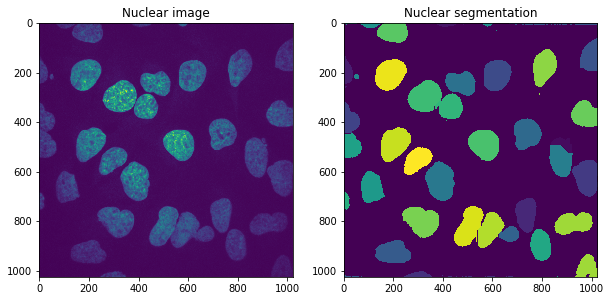

In [7]:
img_seg_nucleus = utils.predictions.starnet_single(model_star, model_unet, img_nucleus)
img_seg_nucleus = fill_label_holes(img_seg_nucleus)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Nuclear image')
ax[0].imshow(img_nucleus)
ax[1].set_title('Nuclear segmentation')
ax[1].imshow(img_seg_nucleus)
plt.show()

#### Cytoplasm – quantile based

In [8]:
@widgets.interact(quantile = widgets.FloatSlider(value=0.75, min=0, max=1, step=0.01, description='Quantile: '))
def g(quantile):
    global img_thresh_cytoplasm
    
    img_smooth = skimage.filters.gaussian(img_cytoplasm, 2)
    img_quantile = np.quantile(img_smooth, quantile)
    img_thresh_cytoplasm = img_smooth > img_quantile
    img_thresh_cytoplasm = ndi.binary_fill_holes(img_thresh_cytoplasm)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title('Cytoplasmic image')
    ax[0].imshow(img_cytoplasm)
    ax[1].set_title('Cytoplasmic threshold')
    ax[1].imshow(img_thresh_cytoplasm)
    plt.show()

interactive(children=(FloatSlider(value=0.75, description='Quantile: ', max=1.0, step=0.01), Output()), _dom_c…

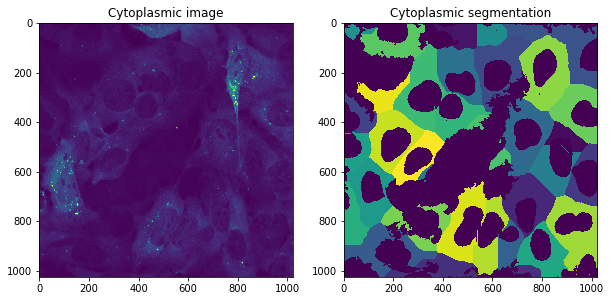

In [10]:
img_seg_cytoplasm = skimage.segmentation.watershed(~img_thresh_cytoplasm, img_seg_nucleus, mask=img_thresh_cytoplasm)
img_seg_cytoplasm = np.where(img_seg_nucleus, 0, img_seg_cytoplasm)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Cytoplasmic image')
ax[0].imshow(img_cytoplasm)
ax[1].set_title('Cytoplasmic segmentation')
ax[1].imshow(img_seg_cytoplasm)
plt.show()

#### Granules – quantile based

In [11]:
@widgets.interact(quantile = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.01, description='Quantile: '))
def g(quantile):
    global var_quantile_granules, quantile_dist_transform
    
    img_smooth = skimage.filters.gaussian(img_granules, 2)
    var_quantile_granules = np.quantile(img_smooth, quantile)
    
    def quantile_dist_transform(img, quantile, return_both=False):
        img_seg = img > quantile
        img_seg_dist = ndi.distance_transform_edt(img_seg)
        if return_both:
            return img_seg, img_seg_dist
        return img_seg_dist

    img_seg_granules, img_seg_granules_dist = quantile_dist_transform(img_smooth, var_quantile_granules, True)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    ax[0].set_title('Granular image')
    ax[0].imshow(img_granules)
    ax[1].set_title('Granular segmentation')
    ax[1].imshow(img_seg_granules)
    ax[2].set_title('Granular distance transform')
    ax[2].imshow(img_seg_granules_dist)
    plt.show()

interactive(children=(FloatSlider(value=0.95, description='Quantile: ', max=1.0, step=0.01), Output()), _dom_c…

## 3. Spot detection
<a id='section3'></a>

To detect spots, one has to input the corresponding channels. Note, the 'first' channel is defined as channel 0.

Parameters:
- Image – frame in time series of images.
- Diameter – expected blob diameter (actual size still measured). When in doubt, round up.
- Minmass – the minimum integrated brightness.
- Maxsize – maximum radius of gyration.
- Percentile – spots must be above percentile. Default is 64.

In [12]:
c_spots = [1, 2]

In [13]:
dfs = [None] * len(c_spots)

@widgets.interact(channel = widgets.Dropdown(options=c_spots, description='Channel: '),
    diameter = widgets.IntSlider(min=1, max=101, step=2, value=15, description='Diameter: '),
    minmass = widgets.IntSlider(min=0, max=1_000_000, step=1000, value=500_000, description='Minmass: '),
    maxsize = widgets.FloatSlider(min=0, max=10, step=0.5, value=5, description='Maxsize: '),
    percentile = widgets.IntSlider(min=0, max=100, step=1, value=64, description='Percentile: ')
)
def g(channel, diameter, minmass, maxsize, percentile):
    global dfs
    
    f = pims.Frame(img[channel])
    df = tp.locate(f, diameter=diameter, minmass=minmass, maxsize=maxsize, percentile=percentile, engine='numba')
    
    df['channel'] = channel
    dfs[c_spots.index(channel)] = df
    
    plt.figure(figsize=(15, 10))
    plt.title(f'Channel {channel}')
    tp.annotate(df, f, color='b', imshow_style={'cmap':'viridis'})
    plt.show()

interactive(children=(Dropdown(description='Channel: ', options=(1, 2), value=1), IntSlider(value=15, descript…

## 4. Pearson correlation coefficient analysis
<a id='section4'></a>

The pearson correlation coefficient (PCC) can be used to quantify colocalization with a intensity weight. The equation is shown below.

\begin{align}
r = \frac{\sum_i\left(I_{1,i} - \bar{I}_1\right)\left(I_{2,i} - \bar{I}_2\right)}{\sqrt{\left(\sum_i \left(I_{1,i} - \bar{I}_1\right)^2\right)\left(\sum_i \left(I_{2,i} - \bar{I}_2\right)^2\right)}}.
\end{align}

The image set is tested for statistical relevance i.e. if the colocalization is greater than simple variance. This is done via scrambling small blocks of the image. The blocks' height and width are equal to the point spread function (PSF). The PCC is then calculated on the scrambled image blocks. The PSF can be approximated using the rayleigh criterion, which in case of these images / microscopes is as follows.

\begin{align}
R_{\text{Confocal}} = \frac{0.4 \times \lambda}{\text{NA}} = \frac{0.4 \times 640\text{ nm}}{1.45} = 278\text{ nm} \rightarrow \text{PSF} \approx 3\text{ px}
\end{align}

Due to the fact that the PSF is close to one pixel, every pixel will be scrambled inside the segmented cellular area. Alternatively – if the PSF were larger – the edges would be mirrored to obtain an image that is a multiple of the PSF. This, however, due to the cellular segmentation (resulting in uneven shapes) is not possible. The widget below can be used to visualize the effect of scrambling on the r-value.

For this analysis, the segmented cytoplasm will give the 'real' PCC value. A box around the segmented mask will be scrambled and will provide information on whether the current cell has a statistically accurate PCC value.

In [ ]:
def coloc_cellbox(img1, img2, roi, psf=3, scrambles=10):
    # Generate cell boxes
    img1_box = extract_mask(roi, img1, psf)
    img2_box = extract_mask(roi, img2, psf)
    
    # Mirror edges (in case box isn't used)
    #img1_mirror = mirror_edges(img1, psf)
    #img2_mirror = mirror_edges(img2, psf)
    
    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_box, psf)
    img2_blocks = img_to_blocks(img1_box, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Scamblin' and obtain R value
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    
    # Unscrambled R value
    img1_unscr, p = stats.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    
    # Probablity
    img1_prob = sum(i > img1_unscr for i in img1_scr) / len(img1_scr)
    
    return img1_scr, img1_prob

In [ ]:
def coloc_cellmask(img1, img2):
    r_unscr, _ = stats.pearsonr(img1.flatten(), img2.flatten())
    return r_unscr

In [ ]:
@interact(t_scrambles = widgets.IntSlider(min=0, max=2000, step=10, value=10, description='Scrambles: '),
          t_cell = widgets.IntSlider(min=1, max=len(np.unique(img0_seg)), value=1, description='Cell: '))

def g(t_scrambles, t_cell):
    cell_mask = img0_seg==t_cell
    
    t_scr, t_prob = coloc_cellbox(img[1], img[2], cell_mask, scrambles=t_scrambles)
    t_unscr = coloc_cellmask(img[1]*cell_mask, img[2]*cell_mask)
    
    # Visualization
    _ = sns.distplot(t_scr, bins=int(np.sqrt(t_scrambles)), label='Scrambles')
    plt.plot([t_unscr, t_unscr], plt.gca().get_ylim(), '-', label='Real image')
    
    plt.title(f'Scrambled histogram vs. "real" image – Prob: {t_prob}')
    plt.xlabel('Pearson correlation coefficient')
    plt.xlim(-1, 1)
    plt.yticks([])
    plt.ylabel(None)
    plt.legend(frameon=False)
    sns.despine(trim=True, bottom=False, left=True)
    plt.show()

## 5. Measure other channels and cell number

As currently only one channel is tracked, one has to calculate the (potential) spot intensity in the second – untracked – channel. In addition, the tracks are assigned to their belonging cells. If a track is detected in the background it is sacrificed.

In [13]:
# Cellular assignment
def assign_cell(df, img_seg):
    def _get_value(img, y, x):
        return img[int(round(y)), int(round(x))]
    
    df['cell'] = df.apply(lambda row: _get_value(img_seg, row['y'], row['x']), axis=1)
    print('Before:', df.index.nunique())
    df = df[df['cell']!=0]
    print('After:', df.index.nunique())
    return df

def assign_granule(df, img, quantile):
    def _get_value(img, y, x, quantile):
        return img[int(y), int(x)]
    
    img = skimage.filters.gaussian(img, 2)
    img = quantile_dist_transform(img, var_quantile_granules)
    
    df['granule'] = df.apply(lambda row: _get_value(img, row['y'], row['x'], quantile), axis=1)
    return df

In [68]:
dfs[0].index.nunique()

32

In [14]:
dfs = [assign_cell(df, img_seg_cytoplasm) for df in dfs]

Before: 53
After: 41
Before: 15
After: 12


## 6. Output metrics

In [15]:
columns = ['file', 'channel', 'cell',
           'y', 'x',
           'mass', 'size', 'ecc',
           'signal', 'raw_mass', 'ep']

df = pd.concat(dfs)
df['file'] = img_file
df = df[columns]

In [16]:
df

,file,channel,cell,y,x,mass,size,ecc,signal,raw_mass,ep
19,DCP1a_6h_1,1,2,21.986593,408.006515,4.959346e+05,4.047838,0.551052,16490.126012,2655920.0,0.023936
115,DCP1a_6h_1,1,29,98.153682,803.605896,4.960438e+05,3.264503,0.469882,19431.677764,2299092.0,0.028040
134,DCP1a_6h_1,1,29,113.149143,778.706352,6.717762e+05,2.306807,0.008327,34997.039318,2594134.0,0.024558
186,DCP1a_6h_1,1,29,154.924164,765.342966,3.837611e+05,2.952081,0.210195,15925.063930,2278329.0,0.028323
230,DCP1a_6h_1,1,13,190.416011,461.490896,8.631197e+05,3.326110,0.350877,35294.746312,2428434.0,0.026399
262,DCP1a_6h_1,1,29,215.571533,866.643434,1.340092e+06,2.944455,0.014501,33120.387421,4602251.0,0.013309
269,DCP1a_6h_1,1,29,215.572205,763.061428,5.187406e+05,3.837039,0.293809,11559.555732,3149390.0,0.019906
287,DCP1a_6h_1,1,29,233.714052,830.921313,4.810939e+05,2.178578,0.153058,26253.107216,1946249.0,0.033765
322,DCP1a_6h_1,1,29,257.884861,792.829671,6.375295e+05,2.926910,0.254461,23479.459626,5382228.0,0.011299
336,DCP1a_6h_1,1,29,273.026500,787.270019,7.299478e+05,3.871896,0.190478,20872.424627,5919187.0,0.010235


In [ ]:
root_out = './out'

os.makedirs(root_out, exist_ok=True)
df.to_csv(f'./out/{img_file}.csv', index=False)